# <center>Network Science</center>

## <center>Home Assignment #2: Network models</center>

### <center>Student: *Boris Tseytlin*</center>

#### <hr /> General Information

**Due Date:** 23.03.2019<br \>
**Late submission policy:** -2 points per day <br \>


Please send your reports to <network.hse.2016@gmail.com> with message subject of the following structure:<br \> **[HSE Networks 2019] *{LastName}* *{First Name}* HA*{Number}***

Support your computations with figures and comments. <br \>
If you are using IPython Notebook you may use this file as a starting point of your report.<br \>
<br \>
<hr \>

## Problems

### Task 1

Consider Barabasi and Albert dynamical grow model. Two main ingredients of this model are *network growing* and *prefferential attachment*. Implement two restricted B&A-based models:
<br \>

**Model A**
<br \>
Lack of prefferential attachment, that is at each time-step form edges uniformly at random while network keeps growing.

**Model B**
<br \>
Lack of growing, that is fix total number of nodes, on each time-step randomly choose one and form edges with prefferential attachment.
<br \>

1. Generate networks according to the models above ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
4. Is scale-free property conserved in these models?

Analyse results with respect to various parameter settings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random
%matplotlib inline

In [265]:
def draw_nx(g):
    plt.figure(figsize=(13,13))
    plt.axis('off')
    nx.draw_networkx(g,
                node_size = 100,
                node_color='black',
                edge_color = 'gray',
                with_labels = False,
                font_size=16,
                alpha=0.7)
    plt.show()

In [202]:
def get_stats_df():
    return pd.DataFrame(columns=['num_nodes','avg_path_len','avg_clustering',
                                 'avg_node_degree','avg_node_age','avg_degree_to_age'])

def get_stats_row(graph, n_nodes):
    row = {
        'num_nodes': n_nodes,
    }
    try:
        row['avg_path_len'] = nx.average_shortest_path_length(graph)
    except (ZeroDivisionError, nx.NetworkXError):
        row['avg_path_len'] = np.NaN
    row['avg_clustering'] = nx.average_clustering(graph)

    degree = pd.Series(graph.degree())
    row['avg_node_degree'] = degree.mean()
    row['avg_node_age'] = np.array(degree.index).mean()
    row['avg_degree_to_age'] = (degree/(np.array(degree.index)+1)).mean()
    return row

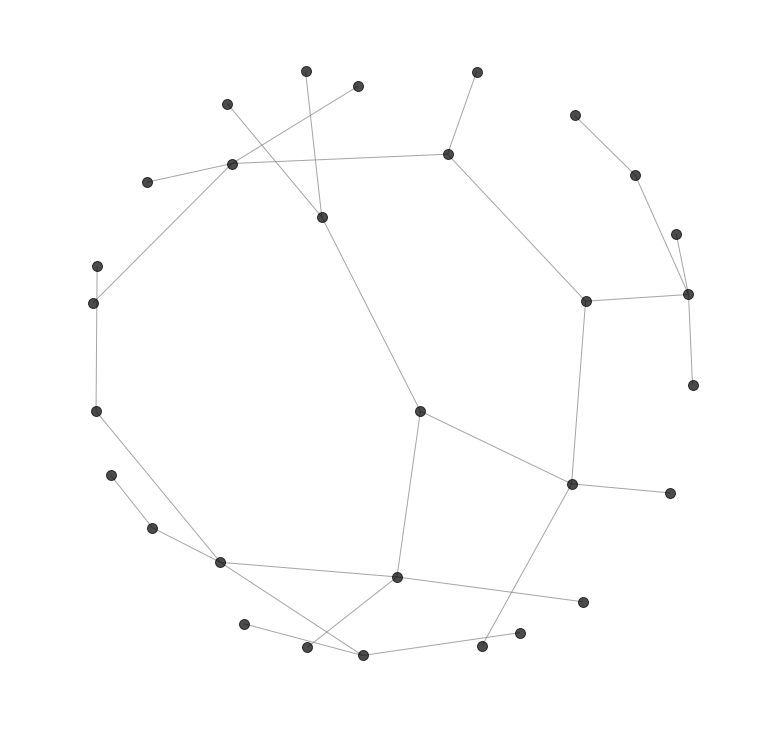

In [203]:
def ba_model_no_pa_generator(n_nodes, m_edges, compute_stats_every=100):
    """Model A.
    
    Barabasi and Albert model, no preferential attachment"""
    graph = nx.Graph()
    graph.add_node(0)
    for i in range(m_edges+1):
        for j in range(i+1, m_edges+1):
            graph.add_edge(i,j)
    
    stats_df = get_stats_df()

    for t in range(m_edges+1, n_nodes):
        initial_nodes = graph.nodes()
        
        # growth
        graph.add_node(t)
        
        nodes_to_pick = list(initial_nodes)
        # connect to m random existing nodes, probability is uniform
        targets = np.random.choice(range(1, t), size=m_edges, replace=False)
        for target in targets:
            graph.add_edge(t, target)            
        
        if (t+1) % compute_stats_every == 0:
            stats_df.loc[len(stats_df)] = get_stats_row(graph, t+1)
            
    return graph, stats_df

draw_nx(ba_model_no_pa_generator(30, 1)[0])

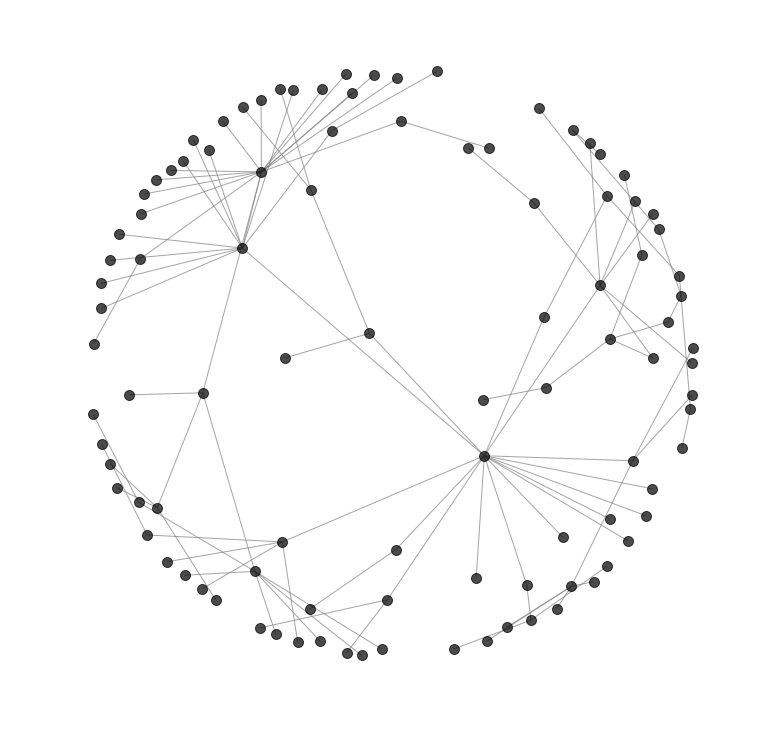

In [276]:
def ba_model_no_growth_generator(n_nodes, m_edges, compute_stats_every=100):
    """Model B
    
    Barabasi and Albert model, no growth, preferential attachment"""
    
    stats_df = get_stats_df()      
    graph = nx.Graph()
    graph.add_nodes_from(range(n_nodes))
    
    for i in range(m_edges+1):
        for j in range(i+1, m_edges+1):
            graph.add_edge(i,j)
        
    for t in range(m_edges+1, n_nodes):
        # preferential attachment
        neighbors = graph.neighbors(t)
        target_nodes = set(range(n_nodes)).difference([t]).difference(neighbors)
        #draw_nx(graph)
        #print(t, target_nodes)
        degrees = pd.Series(graph.degree())[target_nodes].astype(float)
        normed_degrees = (degrees)/(degrees).sum()
        #print(normed_degrees)
        targets = np.random.choice(normed_degrees.index, size=m_edges, p=normed_degrees.values, replace=False)
        for target in targets:
            graph.add_edge(t, target)
            
        if (t+1) % compute_stats_every == 0:
            stats_df.loc[len(stats_df)] = get_stats_row(graph, t+1)
        
    return graph, stats_df
draw_nx(ba_model_no_growth_generator(100, 1, compute_stats_every=10)[0])

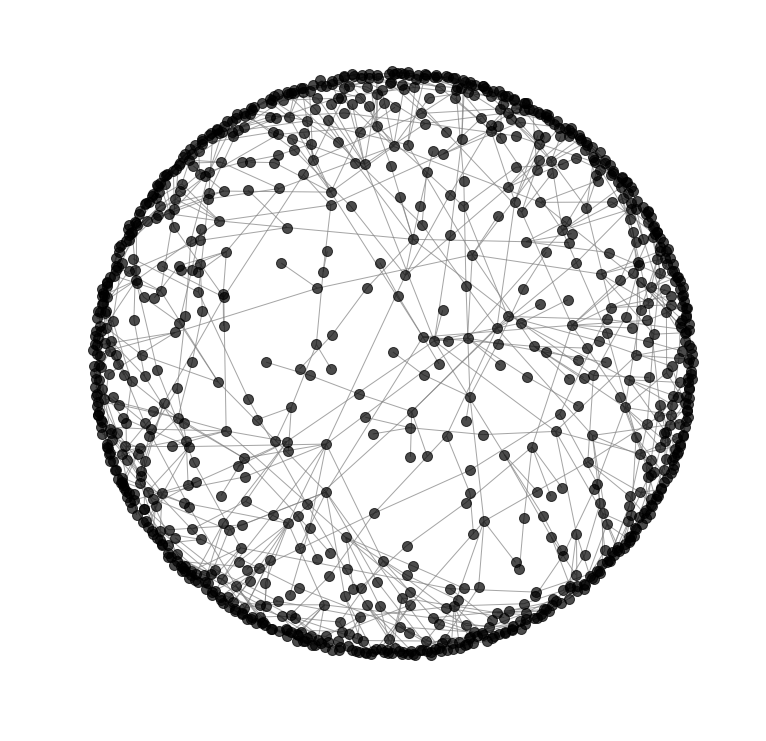

In [206]:
m = 1
graph_a, stats_df_a = ba_model_no_pa_generator(1000, m, compute_stats_every=100)
draw_nx(graph_a)

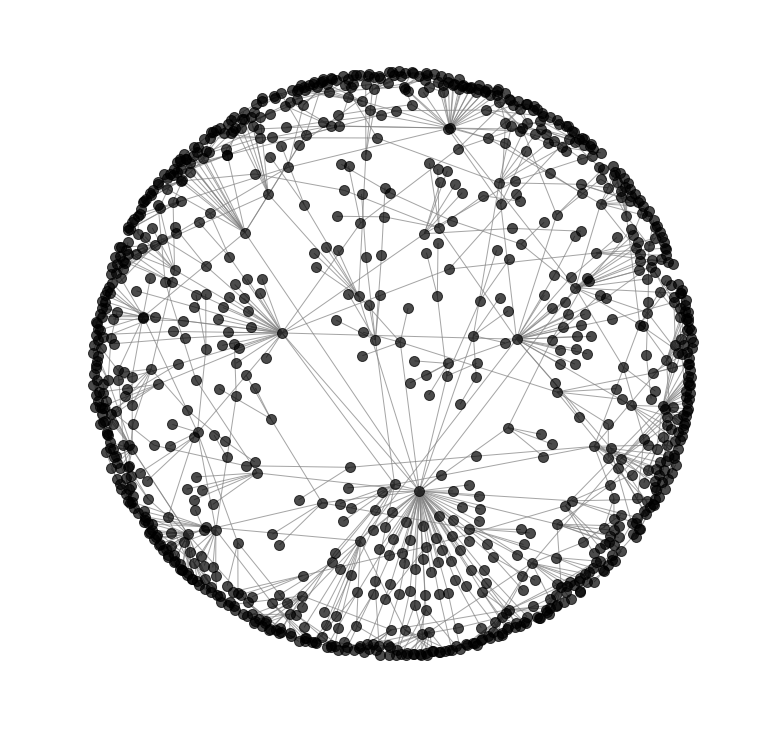

In [277]:
m = 1
graph_b, stats_df_b = ba_model_no_growth_generator(1000, m, compute_stats_every=100)
draw_nx(graph_b)

## Draw PDF/CDF, describe and compute property distributions

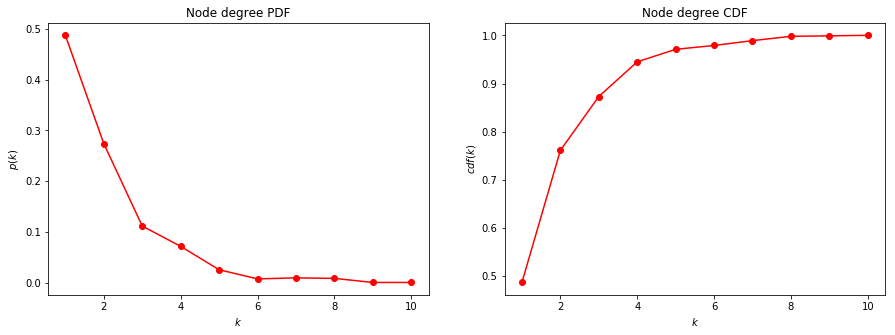

In [240]:
def degree_pdf(graph):
    degree = pd.Series(graph.degree())
    degree = degree.sort_values()
    vcounts = degree.value_counts()
    
    degree_keys = pd.Series(vcounts.index).sort_values().values
    s = vcounts.sum()
    pdf=[float(vcounts[i])/s for i in degree_keys]
    
    return degree_keys, pdf

def plot_pdf(graph):
    degree_keys, pdf = degree_pdf(graph)
    plt.plot(degree_keys, pdf,'-or')
    plt.title('Node degree PDF')
    plt.xlabel('$k$')
    plt.ylabel('$p(k)$')

def degree_cdf(graph):
    degree_keys, pdf = degree_pdf(graph)
    cdf=[sum(pdf[:i+1]) for i in range(len(pdf))]
    
    return degree_keys, cdf

def plot_cdf(graph):
    degree_keys, cdf = degree_cdf(graph)
    plt.plot(degree_keys, cdf,'-or')
    plt.title('Node degree CDF')
    plt.xlabel('$k$')
    plt.ylabel('$cdf(k)$')
    
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plot_pdf(graph_a)
plt.subplot(1,2,2)
plot_cdf(graph_a)
plt.show()

In [279]:
def fit_log_log(degree_vals):
    yh, binEdges=np.histogram(degree_vals, bins=1000)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    idx = np.ix_(yh != 0)
    x_est = np.log(bincenters[idx])
    y_est = np.log(yh[idx])
    s = len(x_est)

    X = np.vstack([np.ones(s), x_est]).T
    Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

    idx = np.argsort(x_est)
    yt = np.exp(X[idx,:].dot(Beta))
    xt = np.exp(X[idx,1])

    a_linreg = -Beta[1]
    c_linreg = Beta[0]
    return a_linreg, c_linreg

fit_log_log(pd.Series(graph_a.degree()))

(2.7455009457961235, 7.211982336742912)

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

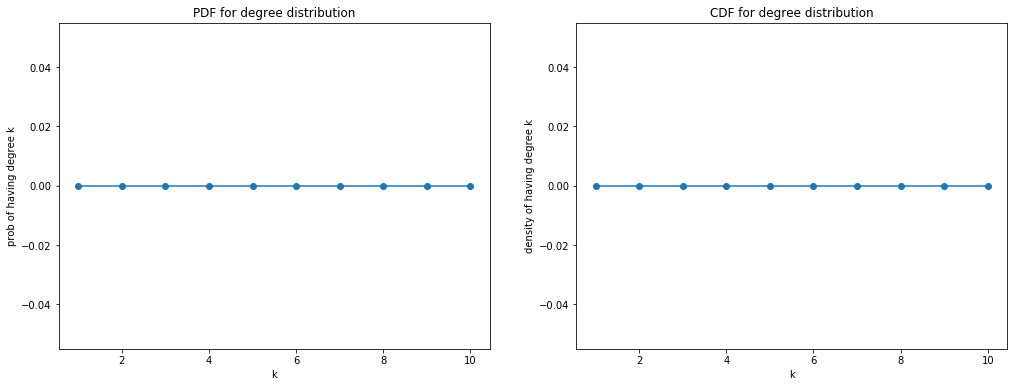

In [210]:
def pdf_cdf(G):
    ''' Plots CDF and PDF of graph G'''
    degree_sequence = sorted(dict(G.degree()).values(), reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    k=sorted(degreeCount.keys())
    s=sum(degreeCount.values())
    pdf=[degreeCount[i]/s for i in k]
    cdf=[sum(pdf[:i+1]) for i in range(len(pdf))]
    
    fig = plt.figure(figsize=(17,6))
    plt.subplot(1,2,1)
    plt.plot(k, pdf,'-o')
    plt.title('PDF for degree distribution')
    plt.xlabel('k')
    plt.ylabel('prob of having degree k')
    
    plt.subplot(1,2,2)
    plt.plot(k, cdf,'-o')
    plt.title('CDF for degree distribution')    
    plt.xlabel('k')
    plt.ylabel('density of having degree k')

    return pdf,cdf,k

pdf_cdf(graph_a)

In [72]:
def plot_hist(degrees, bins=1000):
    yh, binEdges = np.histogram(degrees, bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, yh, '-', lw=1)
    plt.ylabel('count')
    plt.xlabel('degrees')
    return yh, binEdges
    
def plot_log_log(degrees, bins=1000):
    yh, binEdges = np.histogram(degrees, bins=bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.loglog(bincenters, yh, '.', lw=2)
    plt.ylabel('count')
    plt.xlabel('degrees')

def plot_ecdf(x, bins=1000):
    counts, bin_edges = np.histogram(x, bins=bins)
    cdf = np.cumsum(counts)
    plt.plot(bin_edges[1:], cdf)
    
def cdf_empirical(y):
    n = len(y)
    f = np.zeros(n)
    f[0] = 0
    for i in range(1,n):
        f[i] = f[i - 1] + y[i]
    return f/ np.sum(y)

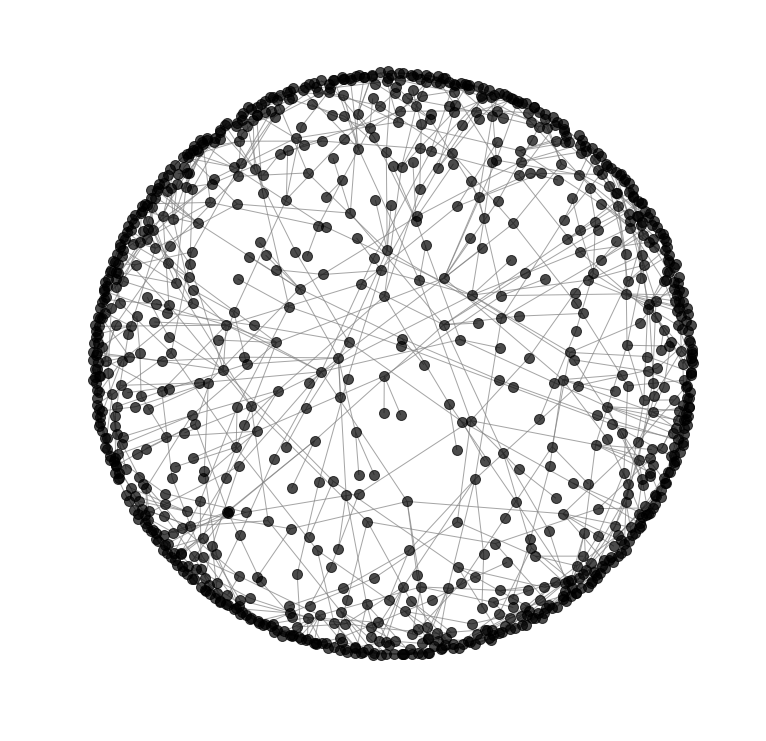

In [214]:
draw_nx(g)

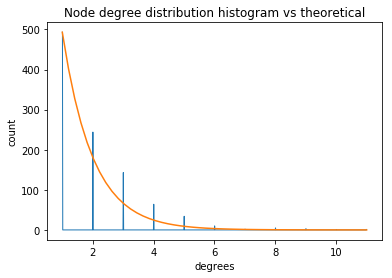

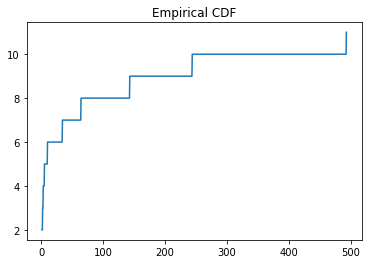

In [211]:
def theoretical_no_pa_degree_distrib(x, m):
    return 1./m * np.exp(-x/m)

degrees = pd.Series(g.degree())
vcounts = degrees.value_counts()
sort_order = np.argsort(vcounts.index)
degree_keys = np.array(vcounts.index)
degree_keys = degree_keys[sort_order]
vcounts = vcounts[degree_keys]
plt.title('Node degree distribution histogram vs theoretical')
yh, _ = plot_hist(degrees)

x = np.linspace(degree_keys.min(), degree_keys.max()) 
y = theoretical_no_pa_degree_distrib(x, m)
y = y / max(y) * max(yh)
plt.plot(x, y)
plt.show()

plt.title('Empirical CDF')
plot_ecdf(vcounts)
plt.show()

In [37]:
stats_df.head()

,num_nodes,avg_path_len,avg_clustering,avg_node_degree,avg_node_age,avg_degree_to_age
0,100.0,3.421414,0.037349,3.940,49.5,0.339858
1,200.0,3.847487,0.023141,3.970,99.5,0.225318
2,300.0,4.107982,0.011472,3.980,149.5,0.170837
3,400.0,4.317782,0.007657,3.985,199.5,0.136464
4,500.0,4.452866,0.005633,3.988,249.5,0.117742


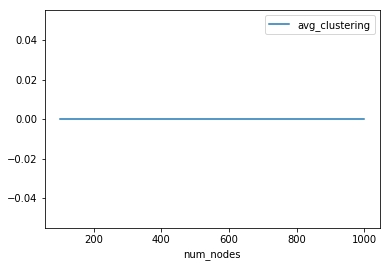

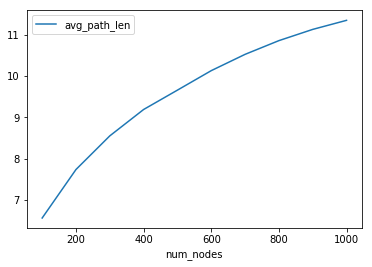

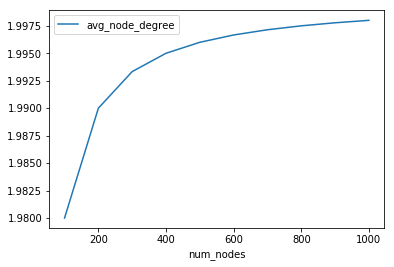

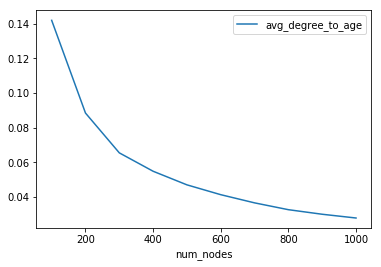

In [213]:
stats_df_a.plot(x='num_nodes', y='avg_clustering')
plt.show()
stats_df_a.plot(x='num_nodes', y='avg_path_len')
plt.show()
stats_df_a.plot(x='num_nodes', y='avg_node_degree')
plt.show()
stats_df_a.plot(x='num_nodes', y='avg_degree_to_age')
plt.show()

In [278]:
def fit_log_log(degree_vals):
    yh, binEdges=np.histogram(degree_vals, bins=1000)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    idx = np.ix_(yh != 0)
    x_est = np.log(bincenters[idx])
    y_est = np.log(yh[idx])
    s = len(x_est)

    X = np.vstack([np.ones(s), x_est]).T
    Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

    idx = np.argsort(x_est)
    yt = np.exp(X[idx,:].dot(Beta))
    xt = np.exp(X[idx,1])

    a_linreg = -Beta[1]
    c_linreg = Beta[0]
    return a_linreg, c_linreg

def alpha_mle(x, x_min):
    x = np.array(x)
    n = x.shape[0]
    return 1+n*1/(np.sum(np.log(x/x_min)))

def alpha_mle_iterative(x, y, x_min):
    ts = -np.sum(y) * np.log(x_min)
    for i in range(len(x)):
        ts += np.log(x[i]) * y[i] 
    return 1. + np.sum(y) / ts 

def cdf_empirical(y):
    n = len(y)
    f = np.zeros(n)
    f[0] = 0
    for i in range(1,n):
        f[i] = f[i - 1] + y[i]
    return f/ np.sum(y)

def cdf_powerlaw(x,x_min,alpha):
    return (1.0 - (float(x_min)/x)** (alpha - 1.0))

def pdf_powerlaw(x,x_min,alpha):
    return (float((alpha - 1.0) * x_min**(alpha - 1.0))/(x**alpha)) 

def kstest(alpha_initial, degree_values):
    vcounts = pd.Series(degree_values).value_counts()
    degree_keys = np.array(vcounts.index)
    sort_order = np.argsort(degree_keys)
    degree_keys = degree_keys[sort_order]
    degree_vcounts = vcounts.values[sort_order]
    max_degree = np.max(degree_values)
    x = degree_keys
    d_val = 1
    x_min = 1
    alpha = alpha_initial
    for i in range(1, max_degree):
        x_ = x[x > i]
        y_ = degree_vcounts[x > i]
        alpha_ = alpha_mle_iterative(x_, y_, i)
        ks_val = max(abs(cdf_empirical(y_) - cdf_powerlaw(x_, i, alpha_)))
        if ks_val < d_val:
            d_val = ks_val
            alpha = alpha_
            x_min = i
    return x_min, alpha, ks_val

def compute_power_law_params(degree_values):
    a_linreg, c_linreg = fit_log_log(degree_values)
    
    x_min_est = float(np.power(c_linreg/(a_linreg-1), 1-a_linreg))

    a_mle = alpha_mle(degree_values, x_min_est)
    sigma_squared = ((a_mle - 1)/np.sqrt(degree_values.shape[0]))**2
    
    x_min, alpha, _ = kstest(a_mle, degree_values)
    return x_min, alpha

x_min, alpha = compute_power_law_params(pd.Series(graph_a.degree()))
print 'Estimated power law xmin, alpha:', x_min, alpha

Estimated power law xmin, alpha: 5 3.806199599187016


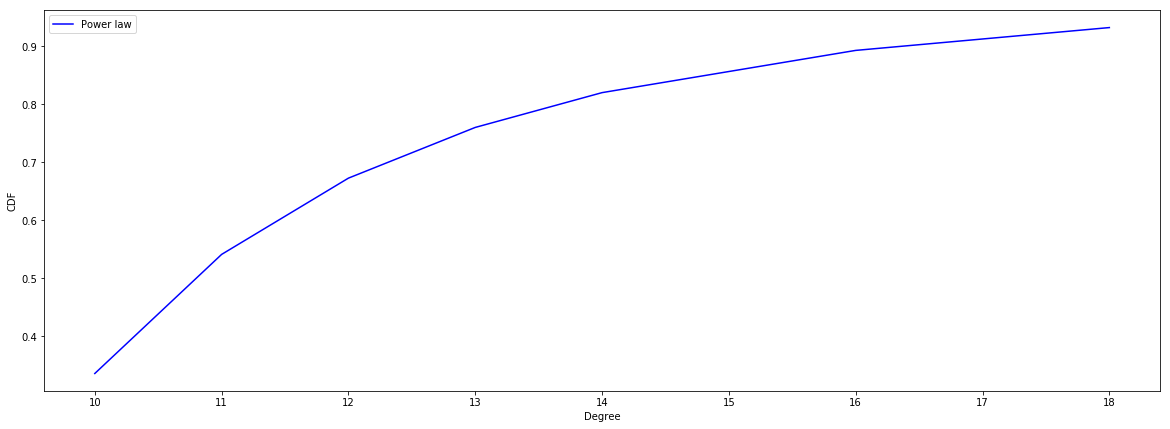

In [40]:
plt.figure(1, figsize=(20, 7))
plt.plot(degree_keys[degree_keys > x_min], cdf_powerlaw(degree_keys[degree_keys > x_min], x_min, alpha), 'b', label='Power law')

plt.ylabel("CDF")
plt.xlabel("Degree")
plt.legend()
plt.show()

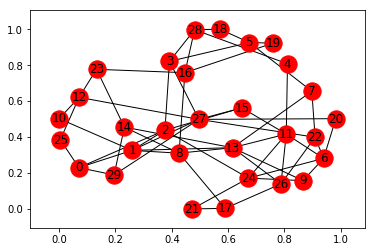

In [41]:
def ba_model_no_growth_generator(n_nodes, m_edges, n_initial=3, compute_stats_every=100):
    """Barabasi and Albert model, no growth, preferential attachment"""
    
    stats_df = get_stats_df()    
    
    graph = nx.complete_graph(n_initial)
    for t in range(n_nodes-n_initial):
        graph.add_node(n_initial+t)
    nodes = graph.nodes()
    for t in range(n_nodes):
        # preferential attachment
        node = t
        for _ in range(m_edges):
            degrees = pd.Series(graph.degree(), dtype=float).drop(node)+1
            normalized_degrees = degrees/degrees.sum()
            draw = np.random.choice(normalized_degrees.index, 1, p=normalized_degrees.values)[0]
            graph.add_edge(node, draw)
            
        if (t+1) % compute_stats_every == 0:
            stats_df.loc[len(stats_df)] = get_stats_row(graph, t+1)
    
    return graph, stats_df
g, _ = ba_model_no_growth_generator(30, 2)
nx.draw_networkx(g)

In [42]:
m = 2
g, stats_df = ba_model_no_growth_generator(1000, m, compute_stats_every=100)

NetworkXError: Graph is not connected.

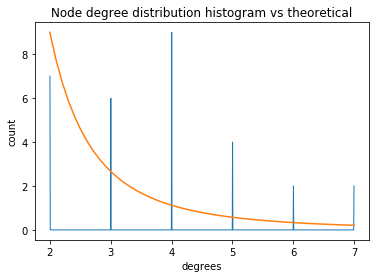

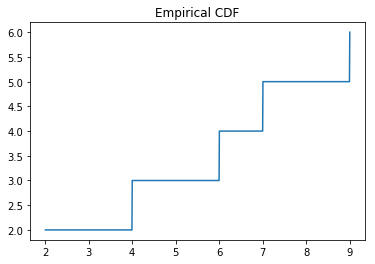

In [43]:
def theoretical_pa_degree_distrib(x, m):
    return 2. * m**2/np.power(x, 3)

degrees = pd.Series(g.degree())
vcounts = degrees.value_counts()
sort_order = np.argsort(vcounts.index)
degree_keys = np.array(vcounts.index)
degree_keys = degree_keys[sort_order]
vcounts = vcounts[degree_keys]

plt.title('Node degree distribution histogram vs theoretical')
yh, _ = plot_hist(degrees)

x = np.linspace(degree_keys.min(), degree_keys.max()) 
y = theoretical_pa_degree_distrib(x, m)
y = y / max(y) * max(yh)
plt.plot(x, y)
plt.show()

plt.title('Empirical CDF')
plot_ecdf(vcounts)
plt.show()

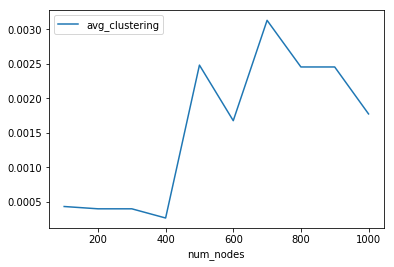

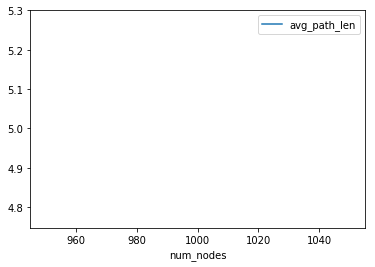

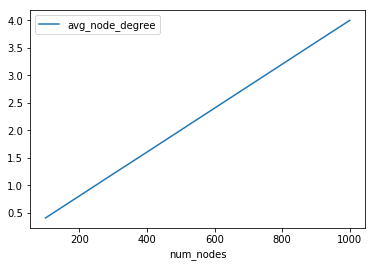

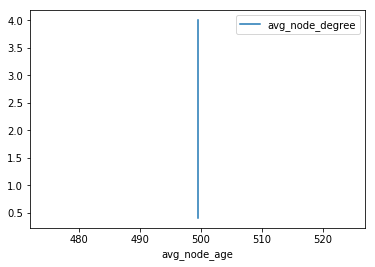

In [135]:
stats_df.plot(x='num_nodes', y='avg_clustering')
stats_df.plot(x='num_nodes', y='avg_path_len')
stats_df.plot(x='num_nodes', y='avg_node_degree')
stats_df.plot(x='avg_node_age', y='avg_node_degree')
plt.show()

### <hr /> Task 2

Consider the following  "Vertex copying model" of growing network.

At every time step a random vertex from already existing vertices is selected and duplicated together with all edges, such that  every edge of the  vertex
* is copied with probability $q$
* is rewired to any other randomly selected vertex with probability $1-q$


Starting state is defined by some small number of randomly connected vertices.

The model can generate both directed and undirected networks.

1. Generate  graphs based on the model ($N > 1000$ nodes)
2. Compute CDF/PDF, describe the distribution and compute\describe its properties.
3. Illustate the following dependencies: 
    * average path length to the number of nodes
    * average clustering coefficient to the number of nodes
    * average node degee to the nodes "age"
    
Analyse results with respect to various parameter settings

0.333333333333
0.666666666667
1.0


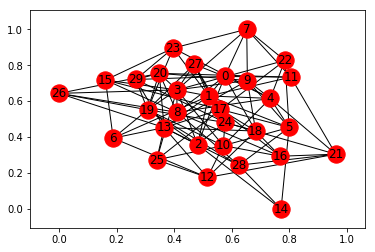

In [110]:
def vertex_copying_model_generator(q, n_nodes, n_initial=3, p_initial=0.5, compute_stats_every=10):
    """Barabasi and Albert model, no preferential attachment"""
    graph = nx.random_regular_graph(2, n_initial)
    
    num_nodes = []
    avg_path_len = []
    avg_clustering = []
    avg_node_degree = []
    avg_node_age = []
    
    for t in range(n_initial, n_nodes):
        nodes = graph.nodes()
        graph.add_node(t)
        sample_node = random.choice(nodes)
        nodes.remove(sample_node)
        
        edges = graph.edges([sample_node])
        for source, target in edges:
            dice = random.random()
            if dice > q:
                # rewire
                target = random.choice(nodes)
            graph.add_edge(t, target)
        if (t+1) % compute_stats_every == 0:
            print(float(t+1)/n_nodes)
            num_nodes.append(t+1)
            try:
                avg_path_len.append(nx.average_shortest_path_length(graph))
            except ZeroDivisionError:
                avg_path_len.append(np.NaN)
            avg_clustering.append(nx.average_clustering(graph))
            
            degree = pd.Series(graph.degree())
            avg_node_degree.append(degree.mean())
            avg_node_age.append(np.array(degree.index).mean())
            
    stats_df = pd.DataFrame({
        'num_nodes': num_nodes,
        'avg_path_len': avg_path_len,
        'avg_clustering': avg_clustering,
        'avg_node_degree': avg_node_degree,
        'avg_node_age': avg_node_age
    })
    return graph, stats_df
nx.draw_networkx(vertex_copying_model_generator(0.1, 30)[0])

In [117]:
g, stats_df = vertex_copying_model_generator(0.4, 1000, compute_stats_every=100)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


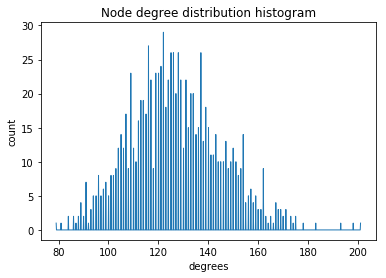

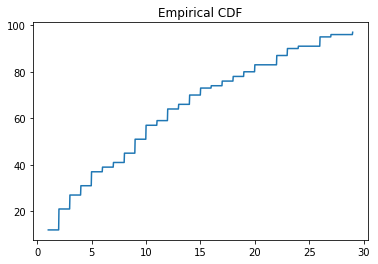

In [118]:
degrees = pd.Series(g.degree())
vcounts = degrees.value_counts()
sort_order = np.argsort(vcounts.index)
degree_keys = np.array(vcounts.index)
degree_keys = degree_keys[sort_order]
vcounts = vcounts[degree_keys]
plt.title('Node degree distribution histogram')
yh, _ = plot_hist(degrees)
plt.show()

plt.title('Empirical CDF')
plot_ecdf(vcounts)
plt.show()

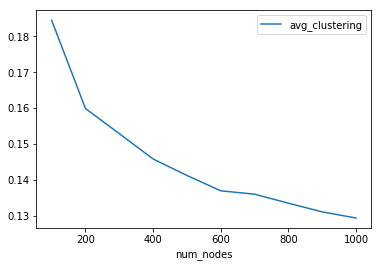

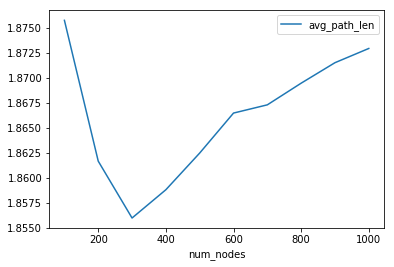

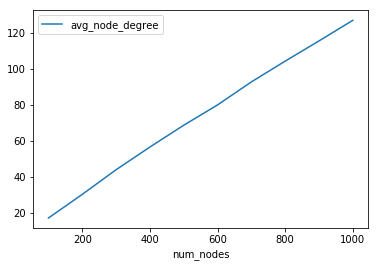

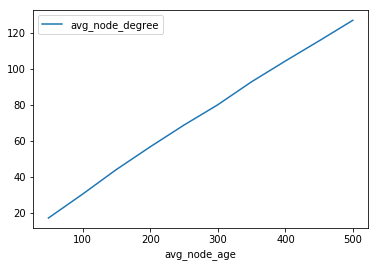

In [119]:
stats_df.plot(x='num_nodes', y='avg_clustering')
stats_df.plot(x='num_nodes', y='avg_path_len')
stats_df.plot(x='num_nodes', y='avg_node_degree')
stats_df.plot(x='avg_node_age', y='avg_node_degree')
plt.show()